#### -- Data points and Query Point Plotting

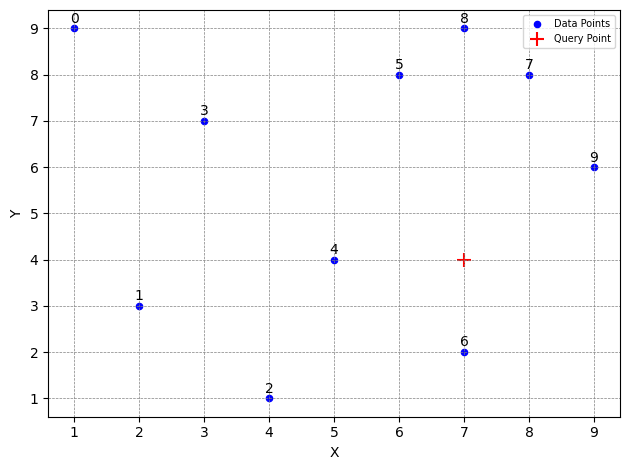

In [1]:
import numpy as np
import matplotlib.pyplot as plt
data_points = np.array([[1, 9], [2, 3], [4, 1], [3, 7], [5, 4], [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]])
query_point = np.array([7, 4])

def plot_dataset(data, query):
    plt.scatter(data[:, 0], data[:, 1], color='blue', s=20, label='Data Points')
    plt.scatter(query[0], query[1], color='red', marker='+', s=100, label='Query Point')
    for i, txt in enumerate(range(len(data))):
        plt.annotate(txt, (data[i][0], data[i][1]), textcoords="offset points", xytext=(0,4), ha='center')
    plt.xlabel('X')
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.ylabel('Y')
    plt.legend(fontsize = 7)

plot_dataset(data_points, query_point)
plt.tight_layout()
plt.show()


#### -- Niave KNN

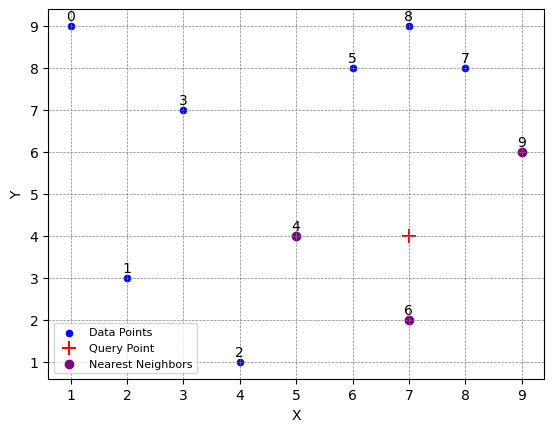

Nearest Neighbors
[[5 4]
 [7 2]
 [9 6]]


In [2]:
def naive_knn(data, query, k):
    distances = [np.linalg.norm(query-point) for point in data]
    indices = np.argsort(distances)[:k]
    sorted_distances = np.sort(distances)[:k]
    return sorted_distances, indices

distances, indices = naive_knn(data_points, query_point, 3)
nearest_neighbor_pts = data_points[indices]
plot_dataset(data_points, query_point)
plt.scatter(nearest_neighbor_pts[:, 0], nearest_neighbor_pts[:, 1], color='purple', label='Nearest Neighbors')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend(fontsize = 8)
plt.show()
print('Nearest Neighbors')
print(nearest_neighbor_pts)

#### -- KDTree

In [3]:
class KDNode:
    def __init__(self, split, leaf_points=None, left=None, right=None):
        self.leaf_points = leaf_points
        self.split = split
        self.left = left
        self.right = right

def build_kdtree(points, min_points, depth=0):
    if len(points) <= min_points:
        return KDNode(split=None, leaf_points=points)

    dim = data_points.shape[1]
    axis = depth % dim
    points = sorted(points, key=lambda x: x[axis])
    median = len(points) // 2

    return KDNode(
        points[median],
        leaf_points=None,
        left=build_kdtree(points[:median], min_points, depth + 1),
        right=build_kdtree(points[median + 1:], min_points, depth + 1)
    )

def distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def knn_search(node, target, k, data, depth=0):

    dim = len(target)
    while node.left is not None:
        axis = depth % dim
        if target[axis] < node.split[axis]:
            node = node.left
            depth += 1
        else:
            node = node.right
            depth += 1

    subset = node.leaf_points
    distances = {tuple(i): distance(target, i) for i in subset}  # Convert array to tuple
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    k_neighbors = sorted_distances[:k]

    return k_neighbors

kdtree = build_kdtree(data_points, min_points =3 )
k_neighbors = knn_search(kdtree, query_point, 3, data_points)
print("Nearest neighbors:", k_neighbors)

Nearest neighbors: [((7, 2), 2.0), ((9, 6), 2.8284271247461903)]


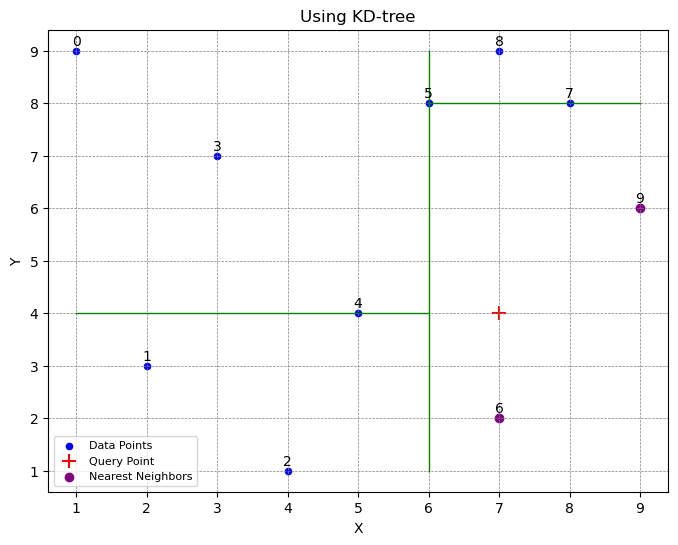

In [4]:
import matplotlib.pyplot as plt

def plot_kdtree(node, xmin, xmax, ymin, ymax, depth=0):
    if node.left is None:
        return

    dim = len(node.split)
    axis = depth % dim
    split_value = node.split[axis]

    # Plot splitting line
    if axis == 0:
        plt.plot([split_value, split_value], [ymin, ymax], color='green', linestyle='-', linewidth=1)
        plot_kdtree(node.left, xmin, split_value, ymin, ymax, depth + 1)
        plot_kdtree(node.right, split_value, xmax, ymin, ymax, depth + 1)
    else:
        plt.plot([xmin, xmax], [split_value, split_value], color='green', linestyle='-', linewidth=1)
        plot_kdtree(node.left, xmin, xmax, ymin, split_value, depth + 1)
        plot_kdtree(node.right, xmin, xmax, split_value, ymax, depth + 1)

# Example usage
plt.figure(figsize=(8, 6))
plot_dataset(data_points, query_point)
nearest_neighbor_pts = np.array([neighbor[0] for neighbor in k_neighbors])
plt.scatter(nearest_neighbor_pts[:, 0], nearest_neighbor_pts[:, 1], color='purple', label='Nearest Neighbors')
plot_kdtree(kdtree, np.min(data_points[:, 0]), np.max(data_points[:, 0]), np.min(data_points[:, 1]), np.max(data_points[:, 1]))
plt.legend(fontsize = 8 , loc = 'lower left')
plt.title('Using KD-tree')
plt.show()


#### --LSH (Locality-Sensitive Hashing)

Approximate Nearest Neighbors: [4, 9, 5]


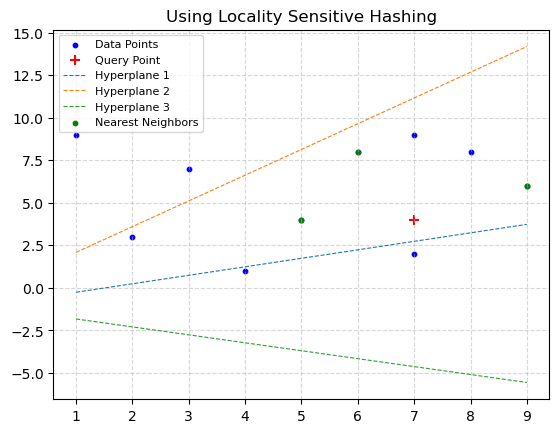

In [5]:
class LSH:
    def __init__(self, num_hyperplanes=10):
        self.num_hyperplanes = num_hyperplanes
        self.projections = None
        self.hash_tables = {i: [] for i in range(2**num_hyperplanes)}

    def fit(self, data_points):
        np.random.seed(69)
        self.projections = np.random.randn(data_points.shape[1] + 1, self.num_hyperplanes)
        X_aug = np.hstack([np.ones((data_points.shape[0], 1)), data_points])
        bin_codes = (X_aug @ self.projections > 0).astype(int)
        for i, hash_code in enumerate(bin_codes):
            bucket_index = int(''.join(map(str, hash_code)), 2)
            self.hash_tables[bucket_index].append(i)

    def query(self, query_point, data_points, k):
        query_point_aug = np.hstack([[1], query_point])
        hash_code = (query_point_aug @ self.projections > 0).astype(int)
        bucket_index = int(''.join(map(str, hash_code)), 2)
        candidate_indices = self.hash_tables[bucket_index]
        distances = [np.linalg.norm(query_point - data_points[i]) for i in candidate_indices]
        sorted_indices = np.argsort(distances)[:k]
        return [candidate_indices[i] for i in sorted_indices]

    def plot_hyperplanes(self, data_points, query_point):
        plt.scatter(data_points[:, 0], data_points[:, 1], color = 'blue' ,label="Data Points"  , s = 10)
        plt.scatter(query_point[0], query_point[1], color='red', label="Query Point", s=50, marker="+")
        for i in range(self.num_hyperplanes):
            x1 = np.array([min(data_points[:, 0]), max(data_points[:, 0])])
            x2 = (-self.projections[0, i] - self.projections[1, i] * x1) / self.projections[2, i]
            plt.plot(x1, x2, label=f'Hyperplane {i+1}' , linestyle = '--' , linewidth = 0.8 , alpha = 1)
        plt.legend()
        plt.title('Using Locality Sensitive Hashing')

lsh = LSH(num_hyperplanes=3)
lsh.fit(data_points)
k = 3
nearest_neighbors = lsh.query(query_point, data_points, k)
print("Approximate Nearest Neighbors:", nearest_neighbors)
nearest_neighbor_pts = data_points[nearest_neighbors]
lsh.plot_hyperplanes(data_points, query_point)
plt.scatter(nearest_neighbor_pts[:, 0], nearest_neighbor_pts[:, 1], color='green', label='Nearest Neighbors' , s = 10)
plt.legend(fontsize = 8)
plt.grid(linestyle = '--' , alpha = 0.5)
plt.show()


#### --Time and Space Comparision for different Conditions

In [6]:
import tracemalloc
import time
from sklearn.neighbors import NearestNeighbors

def metrics(data_size, num_dimensions, k, algo):

    random_data_points = np.random.rand(data_size, num_dimensions)
    random_query_point = np.random.rand(1, num_dimensions)
    if algo == 'kdtree':
        # kdtree = build_kdtree(random_data_points, min_points=50)

        tracemalloc.start()
        start_train_time = time.time()
        kdtree = build_kdtree(random_data_points, min_points=50)
        end_train_time = time.time()

        start_test_time = time.time()
        k_neighbors = knn_search(kdtree, random_query_point[0], k, random_data_points)
        end_test_time = time.time()
        train_time = end_train_time - start_train_time
        _, peak_kd_tree = tracemalloc.get_traced_memory()
        memory = peak_kd_tree / 1024
        tracemalloc.stop()

    elif algo == 'lsh':
        tracemalloc.start()
        start_train_time = time.time()
        lsh = LSH(num_hyperplanes=10)
        lsh.fit(random_data_points)
        end_train_time = time.time()

        start_test_time = time.time()
        k_neighbors = lsh.query(random_query_point[0], random_data_points, k)
        end_test_time = time.time()
        train_time = end_train_time - start_train_time
        _, peak_lsh = tracemalloc.get_traced_memory()
        memory = peak_lsh / 1024
        tracemalloc.stop()

    elif algo == 'naive':
        tracemalloc.start()
        train_time = 0

        start_test_time = time.time()
        distances, indices = naive_knn(random_data_points, random_query_point, k)
        nearest_neighbor_pts = random_data_points[indices]
        end_test_time = time.time()
        _, peak_naive = tracemalloc.get_traced_memory()
        memory = peak_naive / 1024
        tracemalloc.stop()

    test_time = end_test_time - start_test_time
    return train_time, test_time, memory

data_size = 10000
num_dimensions = 10
k = 3
print(f"The train timing, test timing and memory usage for {data_size} samples of {num_dimensions} dimensions to find {k} nearest neighbors:")
print("Using naive KNN:")
print(metrics(data_size, num_dimensions, k, 'naive'))
print("Using KD Tree:")
print(metrics(data_size, num_dimensions, k, 'kdtree'))
print("Using LSH:")
print(metrics(data_size, num_dimensions, k, 'lsh'))


The train timing, test timing and memory usage for 10000 samples of 10 dimensions to find 3 nearest neighbors:
Using naive KNN:
(0, 0.11604785919189453, 552.53125)
Using KD Tree:
(0.061767578125, 0.0010042190551757812, 1562.671875)
Using LSH:
(0.3715996742248535, 0.0, 1860.46875)


In [7]:
def plot_metrics(xlabel, sizes, train_time_naive, test_time_naive, memory_naive,
                 train_time_kdtree, test_time_kdtree, memory_kdtree,
                 train_time_lsh, test_time_lsh, memory_lsh):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    axs[0].plot(sizes, train_time_naive, label="Naive KNN", color='blue')
    axs[0].plot(sizes, train_time_lsh , label="LSH KNN", color='green')
    axs[0].plot(sizes, train_time_kdtree, label="KD-tree KNN", color='orange')
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel("Time (s)")
    axs[0].set_title("Training Time")
    axs[0].tick_params(axis='both', labelsize=8)
    axs[0].legend(fontsize = 8)

    axs[1].plot(sizes, test_time_naive, label="Naive KNN", color='blue')
    axs[1].plot(sizes, test_time_lsh , label="LSH KNN", color='green')
    axs[1].plot(sizes, test_time_kdtree, label="KD-tree KNN", color='orange')
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel("Time (s)")
    axs[1].set_title("Testing Time")
    axs[1].tick_params(axis='both', labelsize=8)
    axs[1].legend(fontsize = 8)

    axs[2].plot(sizes, memory_naive, label="Naive KNN", color='blue')
    axs[2].plot(sizes, memory_lsh, label="LSH KNN", color='green')
    axs[2].plot(sizes, memory_kdtree, label="KD-tree KNN", color='orange')
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylabel("Memory (KB)")
    axs[2].set_title("Memory Usage")
    axs[2].tick_params(axis='both', labelsize=8)
    axs[2].legend(fontsize = 8)

    plt.tight_layout()
    plt.show()


#### -- Comparision with Dataset size

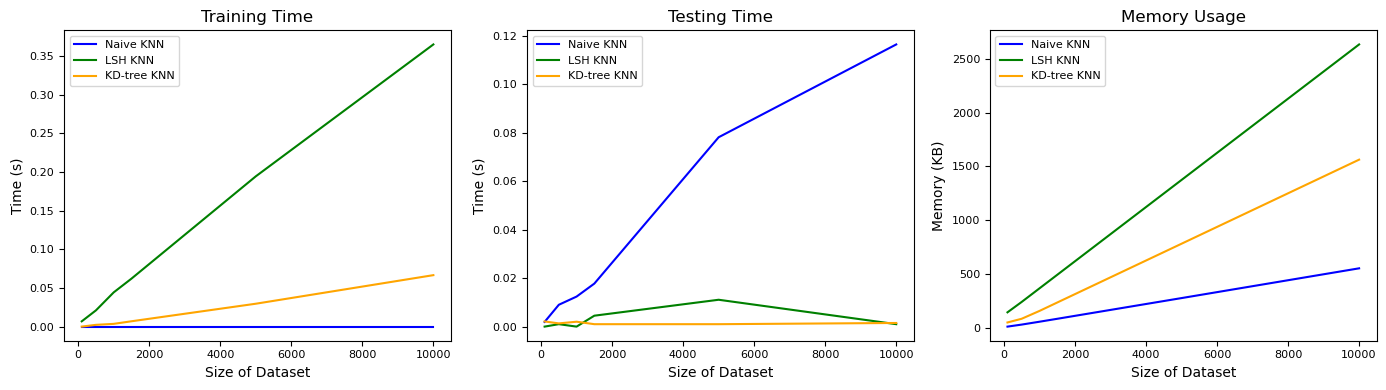

In [8]:
dataset_sizes = [100, 500, 1000, 1500, 5000, 10000]
train_time_naive = []
train_time_lsh = []
train_time_kdtree = []
test_time_naive = []
test_time_lsh = []
test_time_kdtree = []
memory_naive = []
memory_lsh = []
memory_kdtree = []

for size in dataset_sizes:
    train_time, test_time, memory = metrics(size, 20, 5, 'naive')
    train_time_naive.append(train_time)
    test_time_naive.append(test_time)
    memory_naive.append(memory)

    train_time, test_time, memory = metrics(size, 20, 5, 'kdtree')
    train_time_kdtree.append(train_time)
    test_time_kdtree.append(test_time)
    memory_kdtree.append(memory)

    train_time, test_time, memory = metrics(size, 20, 5, 'lsh')
    train_time_lsh.append(train_time)
    test_time_lsh.append(test_time)
    memory_lsh.append(memory)

plot_metrics('Size of Dataset', dataset_sizes, train_time_naive, test_time_naive, memory_naive,
             train_time_kdtree, test_time_kdtree, memory_kdtree,
             train_time_lsh, test_time_lsh, memory_lsh)


#### -- Comparision of Time and Memory with Number of Dimensions

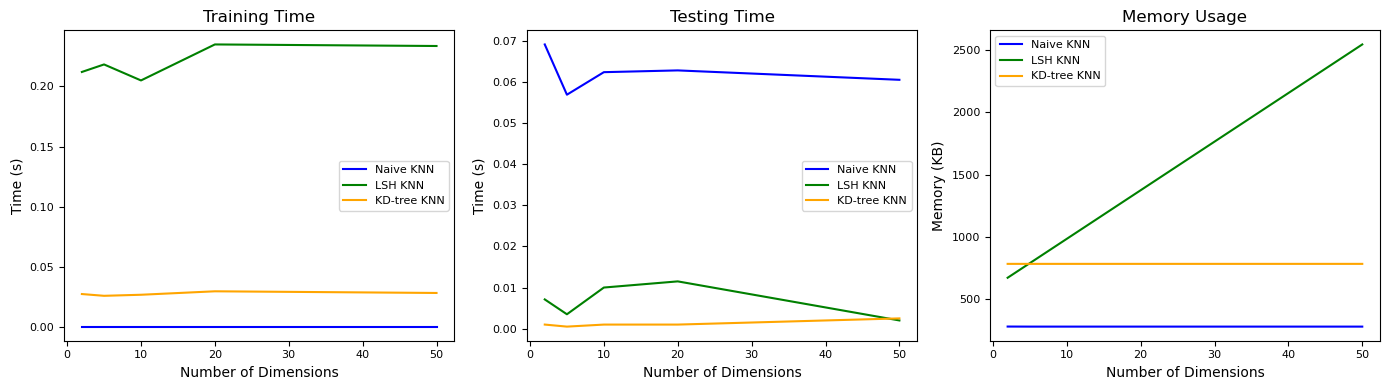

In [9]:
dimensions = [2, 5, 10, 20, 50]
train_time_naive = []
train_time_lsh = []
train_time_kdtree = []
test_time_naive = []
test_time_lsh = []
test_time_kdtree = []
memory_naive = []
memory_lsh = []
memory_kdtree = []

for size in dimensions:
    train_time, test_time, memory = metrics(5000, size, 5, 'naive')
    train_time_naive.append(train_time)
    test_time_naive.append(test_time)
    memory_naive.append(memory)

    train_time, test_time, memory = metrics(5000, size, 5, 'kdtree')
    train_time_kdtree.append(train_time)
    test_time_kdtree.append(test_time)
    memory_kdtree.append(memory)

    train_time, test_time, memory = metrics(5000, size, 5, 'lsh')
    train_time_lsh.append(train_time)
    test_time_lsh.append(test_time)
    memory_lsh.append(memory)

plot_metrics('Number of Dimensions', dimensions, train_time_naive, test_time_naive, memory_naive,
             train_time_kdtree, test_time_kdtree, memory_kdtree,
             train_time_lsh, test_time_lsh, memory_lsh)


#### -- Comparision of Time and Memory with k (Nearest Neighbours) values

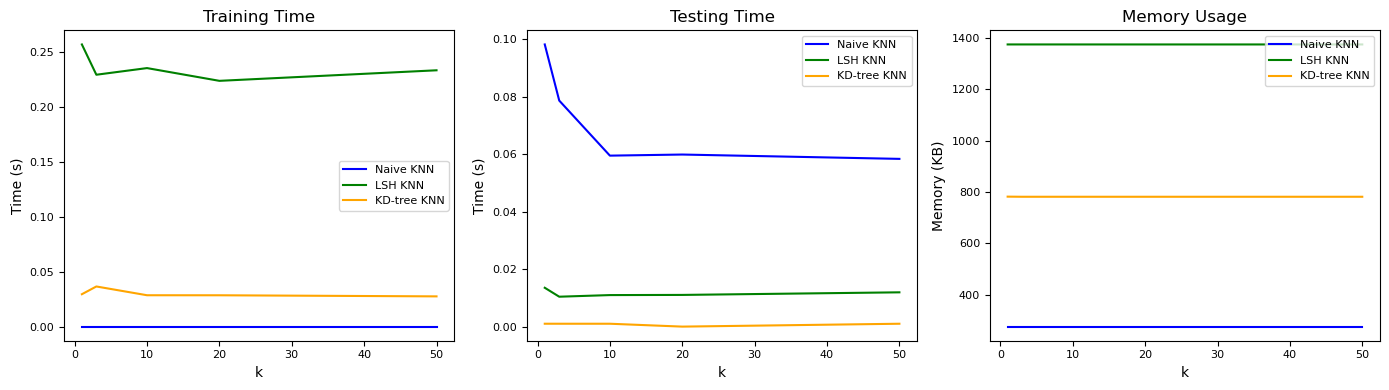

In [10]:
k_values = [1, 3, 10, 20, 50]
train_time_naive = []
train_time_lsh = []
train_time_kdtree = []
test_time_naive = []
test_time_lsh = []
test_time_kdtree = []
memory_naive = []
memory_lsh = []
memory_kdtree = []

for size in k_values:
    train_time, test_time, memory = metrics(5000, 20, size, 'naive')
    train_time_naive.append(train_time)
    test_time_naive.append(test_time)
    memory_naive.append(memory)

    train_time, test_time, memory = metrics(5000, 20, size, 'kdtree')
    train_time_kdtree.append(train_time)
    test_time_kdtree.append(test_time)
    memory_kdtree.append(memory)

    train_time, test_time, memory = metrics(5000, 20, size, 'lsh')
    train_time_lsh.append(train_time)
    test_time_lsh.append(test_time)
    memory_lsh.append(memory)

plot_metrics('k', k_values, train_time_naive, test_time_naive, memory_naive,
             train_time_kdtree, test_time_kdtree, memory_kdtree,
             train_time_lsh, test_time_lsh, memory_lsh)


#### -- Now, in a 2d randomly generate dataset (100 Data points ) and visually show how many of the $ K $ closest neighbors appx. miss out due to their approximate nature. Also show the partitions in the 2d space. 

In [11]:
# Generate random 2D data
np.random.seed(0)
data_points = np.random.rand(100, 2) * 100  
query_point = np.random.rand(2) * 100    

k = 5                                        
# Exact Nearest Neighbors
distances = [np.linalg.norm(query_point - point) for point in data_points]
exact_neighbors_indices = np.argsort(distances)[:k]
exact_neighbors = data_points[exact_neighbors_indices]

# Approximate Nearest Neighbors (LSH)
lsh = LSH(num_hyperplanes=3)
lsh.fit(data_points)
approx_neighbors_indices = lsh.query(query_point, data_points, k)
approx_neighbors = data_points[approx_neighbors_indices]
missed_neighbors = set(exact_neighbors_indices) - set(approx_neighbors_indices)

#### -- Plot Data Points, Query Point, Hyperplanes, and Neighbors and Visualize Partition

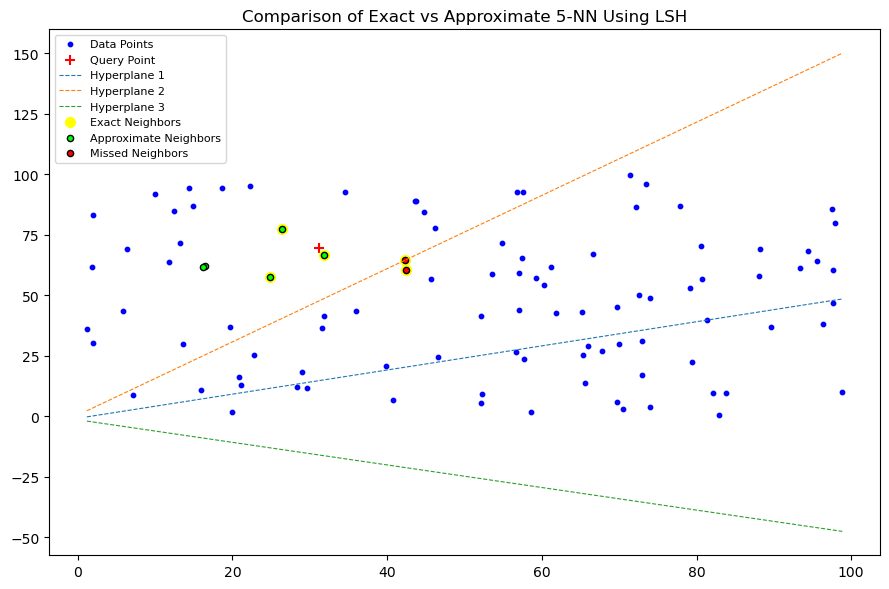

In [12]:
plt.figure(figsize = (9 ,6))
lsh.plot_hyperplanes(data_points, query_point)

# Plot Exact Neighbors
plt.scatter(exact_neighbors[:, 0], exact_neighbors[:, 1], color='yellow', label='Exact Neighbors', s=50)

# Plot Approximate Neighbors
plt.scatter(approx_neighbors[:, 0], approx_neighbors[:, 1], color='lime', label='Approximate Neighbors', s=20, edgecolors= 'k')

# Highlight missed neighbors
missed_neighbors = set(exact_neighbors_indices) - set(approx_neighbors_indices)

for i, point in enumerate(missed_neighbors):
    if i == 0: 
        plt.scatter(data_points[point, 0], data_points[point, 1], color='red', s=20, edgecolor='k', label='Missed Neighbors')
    else:
        plt.scatter(data_points[point, 0], data_points[point, 1], color='red', s=20, edgecolor='k')

plt.legend(fontsize = 8)
plt.title(f"Comparison of Exact vs Approximate {k}-NN Using LSH")
plt.tight_layout()
plt.show()
